# FOV model
## renew on 2024-4-14

April Fool's Day Celebration Codes

## Setup

In [33]:
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc as pm
import pytensor.tensor as pt
import xarray as xr
import random
az.style.use("arviz-darkgrid")

### Load data

Allfishtrial = pd.read_csv('tips.csv')
Allfishtrial.tail()

BRWR_fishid = pd.Categorical(Allfishtrial['fish_id'],
                     categories=['fish3', 'fish7', 'fish9', 'fish10']).codes
BRWR_sessiontype = pd.Categorical(Allfishtrial['session_type'],
                     categories=['Baseliine', 'Rotation', 'Washout', 'ReRotation']).codes


groups_fishid = len(np.unique(BRWR_fishid))


Priors calculation， should get these from raw data

In [34]:
first_day_value = 1
first_trial_value = 1

In [35]:
def gamma_shra_from_modesd(m, s):
    v = s**2
    ra = (m + np.sqrt(m**2 + 4*v)) / (2*v)
    sh = 1+m*ra
    return sh,ra

In [36]:
stage_list = ['baseline', 'rotation', 'washout', 'savings', 'washout 2']


In [37]:


sim = {
#------------------------------------------------------------------------------------------
#    the parameter of μ_μd
    # The amount of learning across fish (for each stage)   For the normal distribution
    "μ_Aμμ": [-1, 5, -1, 5, -1],
    "σ_Aμμ": [5, 5, 5, 5, 5],
 
    # Time constant of learning across fish (for each stage)    For the the gamma distrition 
    "m_τμμ": [4, 4, 4, 4, 4],
    "σ_τμμ": [1.5, 1.5, 1.5, 1.5, 1.5],

    # End point of learning across fish (for each stage)    For the normal ditribution
    "μ_μμ_inf": [0, 0, 0, 0, 0],
    "σ_μμ_inf": [1, 1, 1, 1, 1],

#------------------------------------------------------------------------------------------
#   the parameter of σ_μd
    # Change in std of days around mean value across fish (for each stage) for the half-normal distribution
    "σ_Aσμ": [1, 1, 1, 1, 1],
     
    # Time std of learning across fish (for each stage)    For the the gamma distrition 
    "m_τσμ": [4, 4, 4, 4, 4],
    "σ_τσμ": [1.5, 1.5, 1.5, 1.5, 1.5],

    # Final std of days around mean value across fish (for each stage) for the half-normal distribution
    "σ_σμ_inf": [0.5, 0.5, 0.5, 0.5, 0.5],

#-------------------------------------------------------------------------------------------
#   the parameter of m_σd
    
    # Mode of change in std of trials around day across fish (for each stage) For the the gamma distrition 
    "m_Amσ": [20, 10, 10, 10, 5],
    "σ_Amσ": [10, 10, 10, 10, 10],

    # Time constant of variance reduction across fish (for each stage) For the the gamma distrition 
    "m_τμσ": [3, 3, 3, 3, 3],
    "σ_τμσ": [1.5, 1.5, 1.5, 1.5, 1.5],
    
    # Mode of final std of trials around day across fish (for each stage) For the the gamma distrition 
    "m_mσ_inf": [5, 5, 5, 5, 5],
    "σ_mσ_inf": [3, 3, 3, 3, 3],
#-----------------------------------------------------------------------------------------------
#   the parameter of σ_σd
    # Std of final std of trials around day across fish (for each stage) for the half-normal distribution
    "σ_Aσσ": [1, 1, 1, 1, 1],


    # Time constant of variance reduction across fish (for each stage) For the the gamma distrition 
    "m_τσσ": [3, 3, 3, 3, 3],
    "σ_τσσ": [1.5, 1.5, 1.5, 1.5, 1.5],
    
    # Mode of final std of trials around day across fish (for each stage) for the half-normal distribution
    "σ_σσ_inf": [3, 3, 3, 3, 3],  





}

sim_df = pd.DataFrame(index=stage_list, columns=sim.keys())
for k,v in sim.items():
    sim_df[k] = v

In [38]:
sim_df

,μ_Aμμ,σ_Aμμ,m_τμμ,σ_τμμ,μ_μμ_inf,σ_μμ_inf,σ_Aσμ,m_τσμ,σ_τσμ,σ_σμ_inf,m_Amσ,σ_Amσ,m_τμσ,σ_τμσ,m_mσ_inf,σ_mσ_inf,σ_Aσσ,m_τσσ,σ_τσσ,σ_σσ_inf
baseline,-1,5,4,1.5,0,1,1,4,1.5,0.5,20,10,3,1.5,5,3,1,3,1.5,3
rotation,5,5,4,1.5,0,1,1,4,1.5,0.5,10,10,3,1.5,5,3,1,3,1.5,3
washout,-1,5,4,1.5,0,1,1,4,1.5,0.5,10,10,3,1.5,5,3,1,3,1.5,3
savings,5,5,4,1.5,0,1,1,4,1.5,0.5,10,10,3,1.5,5,3,1,3,1.5,3
washout 2,-1,5,4,1.5,0,1,1,4,1.5,0.5,5,10,3,1.5,5,3,1,3,1.5,3


In [39]:
fish_list = [3, 7, 9, 10]
days = {'baseline': 25, 'rotation': 15, 'washout': 10, 'savings': 15, 'washout 2': 10}

# Initialize an empty list to store the data
data = []

# Generate data for each fish, epoch, day, and trial
for f in fish_list:
    for stage in stage_list:
        sim_s = sim_df.loc[stage]
        
        # Parameters for mean of days
        A_mumu = np.random.normal(loc=sim_s["μ_Aμμ"], scale=sim_s["σ_Aμμ"])
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_τμμ"], sim_s["σ_τμμ"])
        tau_mumu = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
        mumu_inf = np.random.normal(loc=sim_s["μ_μμ_inf"], scale=sim_s["σ_μμ_inf"])        
        
        # Parameters for std of days
        A_sdmu = np.abs(np.random.normal(loc=0, scale=sim_s["σ_Aσμ"]))
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_τσμ"], sim_s["σ_τσμ"])
        tau_sdmu = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
        σ_sdmu_inf = np.abs(np.random.normal(loc=0, scale=sim_s["σ_σμ_inf"]))

        
        # Parameters for std of trials within day
        # m_σd
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_Amσ"], sim_s["σ_Amσ"])
        A_musd = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_τμσ"], sim_s["σ_τμσ"])
        tau_musd = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_mσ_inf"], sim_s["σ_mσ_inf"])
        mu_sd_inf = np.random.gamma(shape=tau_sh, scale=1/tau_ra) 


        #σ_σd
        A_sdsd = np.abs(np.random.normal(loc=0, scale=sim_s["σ_Aσσ"])) 
        tau_sh, tau_ra = gamma_shra_from_modesd(sim_s["m_τσσ"], sim_s["σ_τσσ"])     
        tau_sdsd = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
        σ_sdsd = np.abs(np.random.normal(loc=0, scale=sim_s["σ_σσ_inf"]))         
        





        for day in range(first_day_value, days[stage] + first_day_value):
            num_trials = 6  # Randomly choose number of trials per day
            day_mu_mu = A_mumu*np.exp(-day/tau_mumu) + mumu_inf
            day_mu_sd = A_sdmu*np.exp(-day/tau_sdmu) + σ_sdmu_inf
            day_mu = np.random.normal(loc=day_mu_mu, scale=day_mu_sd)

            day_sd_mu = A_musd*np.exp(-day/tau_musd) + mu_sd_inf
            day_sd_sd = A_sdsd*np.exp(-day/tau_sdsd) + σ_sdsd

            tau_sh, tau_ra = gamma_shra_from_modesd(day_sd_mu, day_sd_sd)  
            day_sd = np.random.gamma(shape=tau_sh, scale=1/tau_ra)
                 


            for trial in range(first_trial_value, num_trials + first_trial_value):
                yds = np.random.normal(loc=day_mu, scale=day_sd)  # Generate random yds
                data.append([f, stage, day, trial, yds])

# Create a pandas DataFrame
df = pd.DataFrame(data, columns=['fish', 'stage', 'day', 'trial', 'yds'])

num_data = df.shape[0]

In [40]:
df

,fish,stage,day,trial,yds
0,3,baseline,1,1,28.385156
1,3,baseline,1,2,4.019160
2,3,baseline,1,3,1.049732
3,3,baseline,1,4,23.825115
4,3,baseline,1,5,-4.799417
...,...,...,...,...,...
1795,10,washout 2,10,2,-5.990837
1796,10,washout 2,10,3,-3.217484
1797,10,washout 2,10,4,-17.071939
1798,10,washout 2,10,5,-0.524874


## Define model

### Priors

#### μ_μ hyper priors
The mean value of the fish behavior for each day

In [41]:
# Priors for Aμμ
df_avg = df.groupby(['fish', 'stage', 'day']).agg({'yds': 'mean'}).reset_index()

mean_first_day = df_avg[df_avg['day'] == first_day_value]
max_day_indices = df_avg.groupby(['fish', 'stage'])['day'].idxmax()
mean_last_day = df_avg.loc[max_day_indices]

merged_data = pd.merge(mean_first_day, mean_last_day, on=['fish', 'stage'], suffixes=('_first', '_last'))
merged_data['difference'] = merged_data['yds_first'] - merged_data['yds_last']

μ_Aμμ = merged_data['difference'].mean()
σ_Aμμ = merged_data['difference'].std()

# Priors for τ_μμ
merged_data['halfway_yds'] = (merged_data['yds_first'] + merged_data['yds_last']) / 2
df_avg = pd.merge(df_avg, merged_data[['fish', 'stage', 'halfway_yds']], on=['fish', 'stage'])

df_avg_below_halfway = df_avg[df_avg['yds'] < df_avg['halfway_yds']].groupby(['fish', 'stage']).agg({'day': 'first'}).reset_index()

mode_τμ = df_avg_below_halfway['day'].mean()*2
σ_τμ = df_avg_below_halfway['day'].std()*2

sh_τμ,ra_τμ = gamma_shra_from_modesd(mode_τμ, σ_τμ)

# Priors for μ_μ∞
μ_μμ_inf = mean_last_day['yds'].mean()
σ_μμ_inf = mean_last_day['yds'].std()


In [42]:
print(f'{μ_Aμμ=}')
print(f'{σ_Aμμ=}')

print(f'{mode_τμ=}')
print(f'{σ_τμ=}')

print(f'{μ_μμ_inf=}')
print(f'{σ_μμ_inf=}')


μ_Aμμ=-0.4983702277907339
σ_Aμμ=8.623832424347267
mode_τμ=5.2
σ_τμ=4.785944332928951
μ_μμ_inf=-0.5275677870698134
σ_μμ_inf=3.643226485944397


#### σ_μ hyper priors
The standard deviation across fish for the mean behavior on each day.

In [63]:
# Priors for Aσμ
mode_Aσμ = merged_data['difference'].std()
std_Aσμ = merged_data['difference'].std()

sh_Aσμ,ra_Aσμ = gamma_shra_from_modesd(mode_Aσμ, std_Aσμ)

# Priors for σ_μ∞
mode_σμ_inf = mean_last_day['yds'].std()
std_σμ_inf = mean_last_day['yds'].std()

sh_σμ_inf,ra_σμ_inf = gamma_shra_from_modesd(mode_σμ_inf, std_σμ_inf)


In [44]:
print(f'{mode_Aσμ=}')
print(f'{std_Aσμ=}')

# print(f'{μ_τμ=}')
print(f'{σ_τμ=}')

print(f'{σ_σμ_inf=}')

mode_Aσμ=8.623832424347267
std_Aσμ=8.623832424347267
σ_τμ=4.785944332928951
σ_σμ_inf=3.643226485944397


#### σ priors
This is the prior for the σ which controls the likelihood.

In [45]:
# Priors for Aμσ
df_std = df.groupby(['fish', 'stage', 'day']).agg({'yds': 'std'}).reset_index()
df_std.rename(columns={'yds': 'std_yds'}, inplace=True)

std_mean = np.mean(df_std['std_yds'])
std_std = np.std(df_std['std_yds'])

mode_σ = std_mean
σ_σ = std_std

sh_σ,ra_σ = gamma_shra_from_modesd(mode_σ,σ_σ)

In [46]:
print(f'{mode_σ=}')
print(f'{σ_σ=}')

print(f'{sh_σ=}')
print(f'{ra_σ=}')

mode_σ=10.271563890749976
σ_σ=7.0219736053772435
sh_σ=3.8821178670817393
ra_σ=0.2805919232685902


### PyMC model code

#### Make codings for fish and stage

In [47]:
fish_index_map = {fish: index for index, fish in enumerate(fish_list)}
stage_index_map = {stage: index for index, stage in enumerate(stage_list)}

# Replace fish numbers with their corresponding indices
df['fish_index'] = df['fish'].map(fish_index_map)
df['stage_index'] = df['stage'].map(stage_index_map)
df['day_index'] = df['day'] - first_day_value

#### Model code

In [65]:
coords = {
    "fish": fish_list,
    "stages": stage_list,
    "data": np.arange(num_data),
}

with pm.Model(coords=coords) as m_yds:
    ### Constants
    fish_ = pm.ConstantData('fish_', df['fish_index'], dims='data')
    stage_ = pm.ConstantData('stage_', df['stage_index'], dims='data')
    day_ = pm.ConstantData('day_', df['day_index'], dims='data')

    ### level 4: Priors for μ_μ, μ_σ, σ_μ, σ_σ
    A_μμ = pm.Normal('A_μμ', mu=μ_Aμμ, sigma=σ_Aμμ, dims=('fish', 'stages'))
    τ_μ = pm.Gamma('τ_μ', alpha=sh_τμ, beta=ra_τμ, dims=('fish', 'stages'))
    μ_μ_inf = pm.Normal('μ_μ_inf', mu=μ_μμ_inf, sigma=σ_μμ_inf, dims=('fish', 'stages'))

    A_σμ = pm.Gamma('A_σμ', alpha=sh_Aσμ, beta=ra_Aσμ, dims=('fish', 'stages'))
    σ_μ_inf = pm.Gamma('σ_μ_inf', alpha=sh_σμ_inf, beta=ra_σμ_inf, dims=('fish', 'stages'))


    ### level 3: Regression equations for μ
    μ_μ = pm.Deterministic('μ_μ', A_μμ[fish_,stage_]*pm.math.exp(-day_ / τ_μ[fish_,stage_]) + μ_μ_inf[fish_,stage_], dims='data' )
    σ_μ = pm.Deterministic('σ_μ', A_σμ[fish_,stage_]*pm.math.exp(-day_ / τ_μ[fish_,stage_]) + σ_μ_inf[fish_,stage_], dims='data')


    ### level 2: Priors for the likelihood
    μ_std = pm.Normal('μ_std', mu=0, sigma=1, dims='data')
    μ = pm.Deterministic('μ', μ_μ + μ_std*σ_μ)    
    # μ = pm.Normal('μ', mu=μ_μ, sigma=σ_μ, dims='data')    
    σ = pm.Gamma('σ', alpha=sh_σ, beta=ra_σ, dims='data')

    
    ### data likelihood level 1
    # y = pm.StudentT('y', mu=μ, sigma=σ, nu=ν, observed=df['yds'], dims='data')
    y = pm.Normal('y', mu=μ, sigma=σ, observed=df['yds'], dims='data')



# Priors

## Sample prior predictive

In [49]:
import pytensor as pyt
pyt.config.exception_verbosity = 'low'


In [66]:
id_yds = pm.sample_prior_predictive(samples=200, model=m_yds)
prior = id_yds.prior
pp = id_yds.prior_predictive
cd = id_yds.constant_data

id_yds

Sampling: [A_μμ, A_σμ, y, μ_std, μ_μ_inf, σ, σ_μ_inf, τ_μ]


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

## Plot priors

### Priors for the hyperparameters

In [51]:
start_day = -24
last_day = start_day

day_ranges = {}
for stage in stage_list:
    day_ranges[stage] = np.arange(last_day, last_day+days[stage])
    last_day = np.max(day_ranges[stage])+1

In [52]:
def plot_hyperparameter_time_course(A_param, τ_param, inf_param, param_name):
    fig, axes = plt.subplots(len(fish_list), 1, figsize=(25, 10)) # Adjust the size as needed
    num_draws_to_plot = 20

    for fish_id,fish_index in fish_index_map.items():
        draws_f = np.random.choice(prior.draw.values, size=num_draws_to_plot, replace=False)
        for stage_id,stage_index in stage_index_map.items():
            prior_fs = prior.sel({'fish': fish_id, 'stages': stage_id, 'draw': draws_f}).squeeze()
            A_fs = prior_fs[A_param]
            inf_fs = prior_fs[inf_param]
            τ_fs = prior_fs[τ_param]
            
            stage_days = xr.DataArray(np.arange(days[stage_id]), dims="days")
            param_vals = A_fs * np.exp(-stage_days / τ_fs) + inf_fs
            
            ax = axes[fish_index] # Get the specific subplot
            ax.plot(day_ranges[stage_id], param_vals.values.T, alpha=0.4, label=f"{stage_id}")
            ax.set_xlabel("Days")
            ax.set_ylabel(param_name)
            ax.set_title(f"Fish {fish_id}")

    fig.suptitle(f'Prior Predictive Checks for {param_name}', fontsize=16)  # Add a main title here
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
    plt.tight_layout(pad=4.0)
    plt.show()

C:\Users\donchin\AppData\Local\Temp\ipykernel_28824\3584767996.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


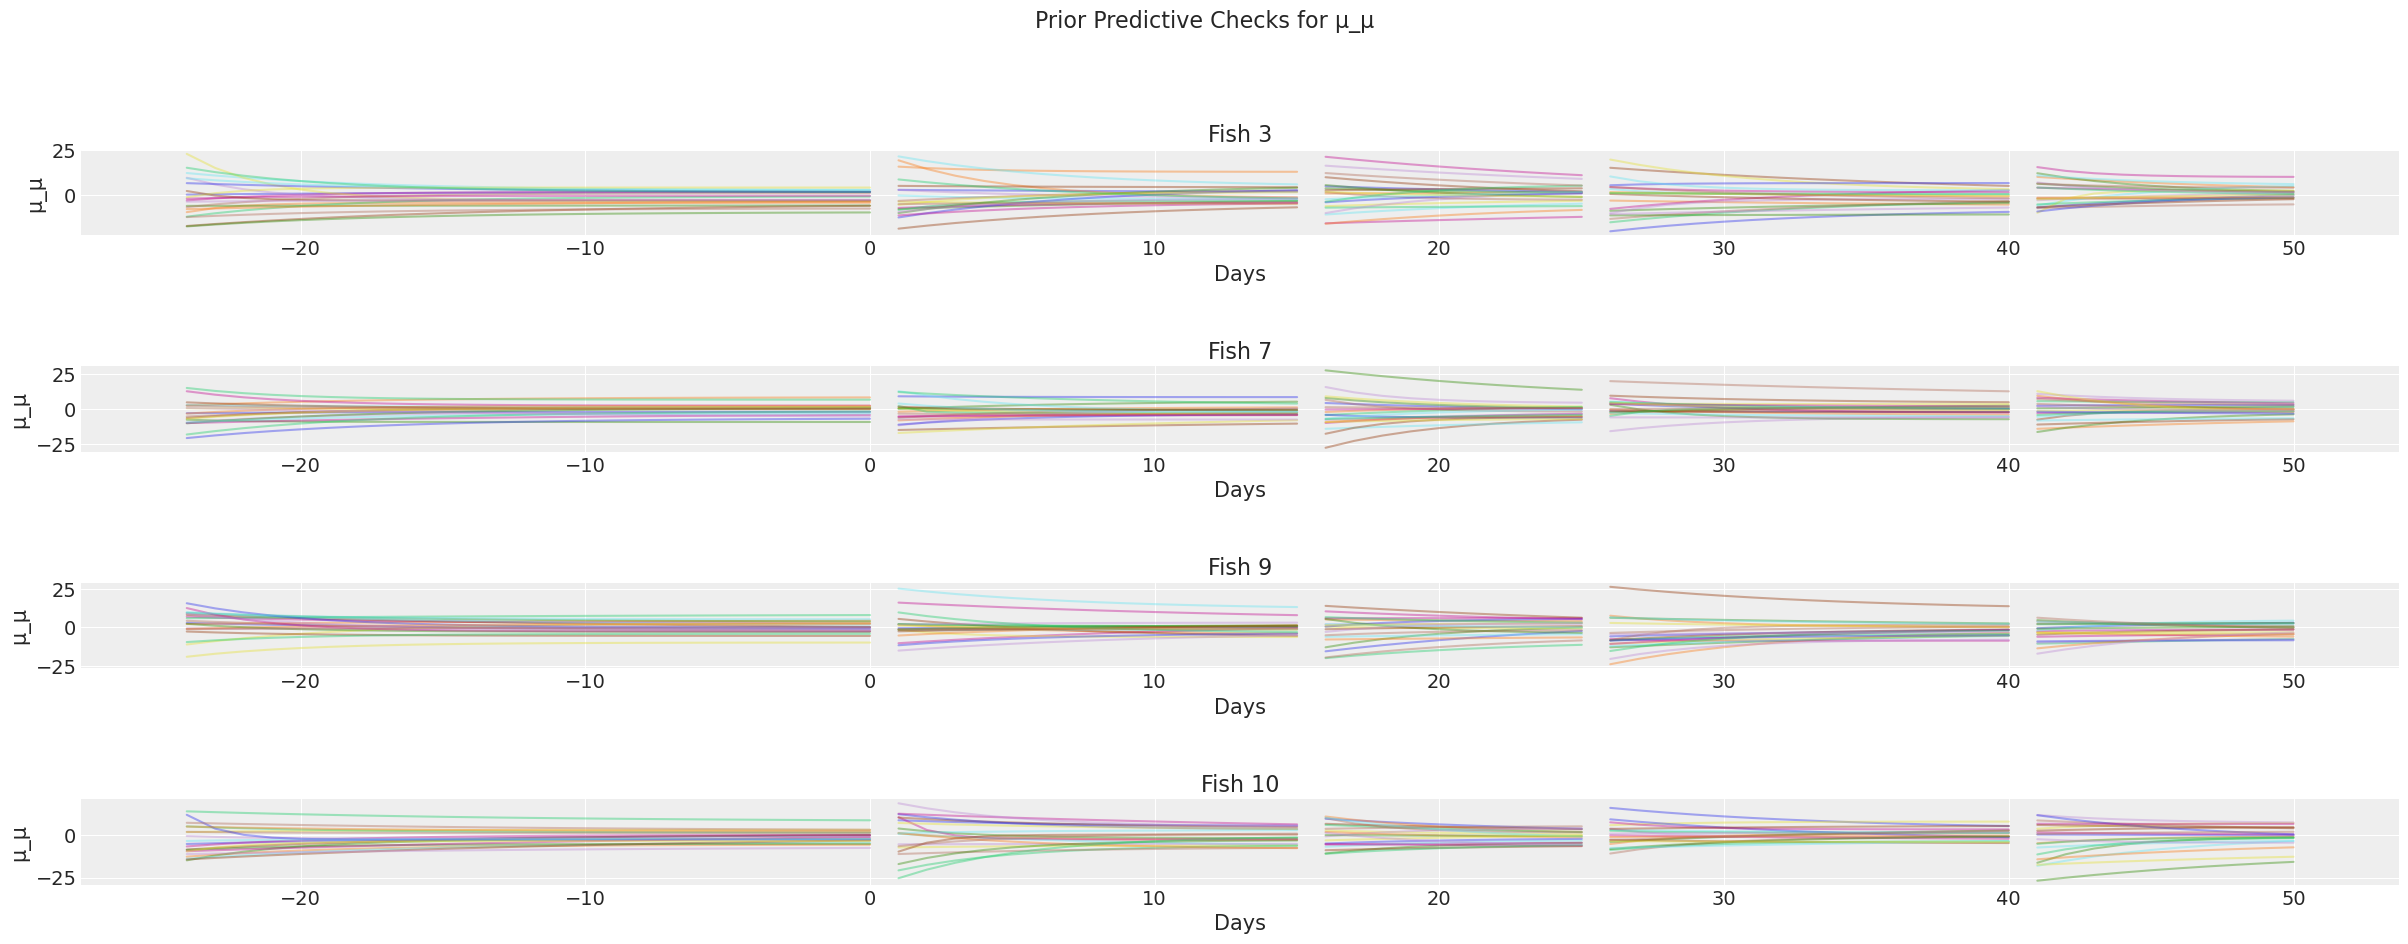

In [67]:
plot_hyperparameter_time_course("A_μμ", "τ_μ", "μ_μ_inf", "μ_μ")


C:\Users\donchin\AppData\Local\Temp\ipykernel_28824\3584767996.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


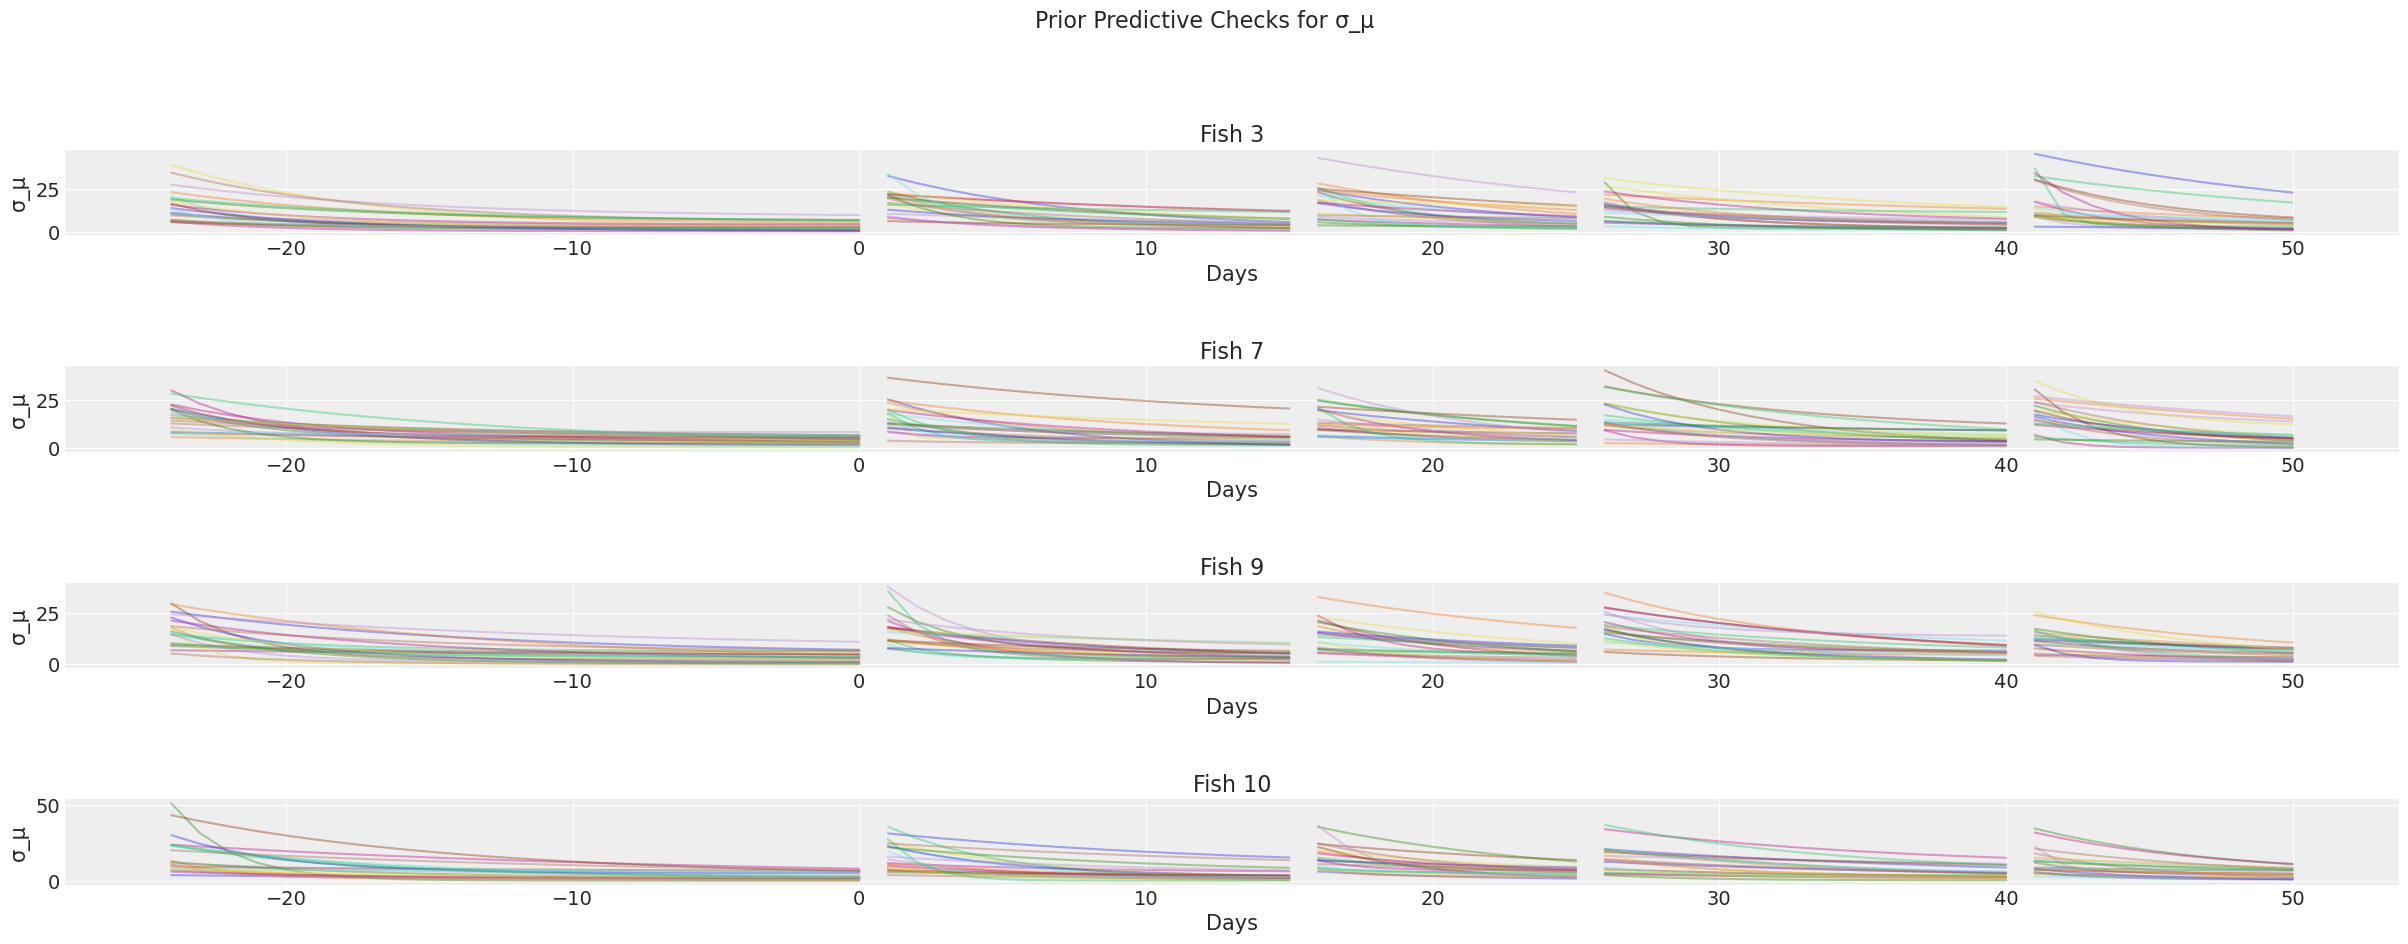

In [54]:
plot_hyperparameter_time_course("A_σμ", "τ_μ", "σ_μ_inf", "σ_μ")


### Plot prior parameters

In [55]:
index_stage_map = {v:k for k,v in stage_index_map.items()}
day_range_ = xr.ones_like(cd.day_)
for i in day_range_['data']:
    stage_id = index_stage_map[cd.stage_[i].item()]
    day_range_[i] = day_ranges[stage_id][cd.day_[i].item()]

In [56]:
def plot_data_time_course_across_fish(day, data, data_name):
    plot_ds = xr.Dataset(data_vars={'day': day, 'data': data})

    fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

    plot_df = plot_ds.to_dataframe().reset_index()
    plot_df['day'] = plot_df['day'].astype(int)
    sns.violinplot(data=plot_df, x='day', y='data', ax=ax, inner='quartile')
    ax.set_title(f'{data_name}')
    ax.set_xlabel('Days')
    ax.set_ylabel(f'{data_name}')

MemoryError: Unable to allocate 2.41 GiB for an array with shape (1800, 1, 200, 1800) and data type int32

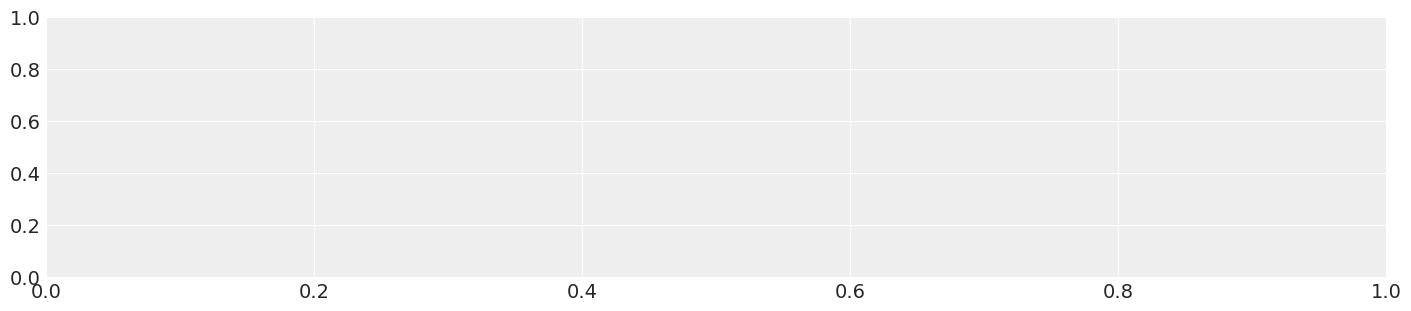

In [57]:
plot_ds = xr.Dataset(data_vars={'day': day_range_, 'fish': cd.fish_, 'mu_y': prior['μ']})

fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

plot_df = plot_ds.to_dataframe().reset_index()
plot_df['day'] = plot_df['day'].astype(int)
sns.violinplot(data=plot_df, x='day', y='mu_y', ax=ax, inner='quartile')
ax.set_title(f'Prior mu_y')
ax.set_xlabel('Days')
ax.set_ylabel('mu_yds')

Text(0, 0.5, 'sigma_yds')

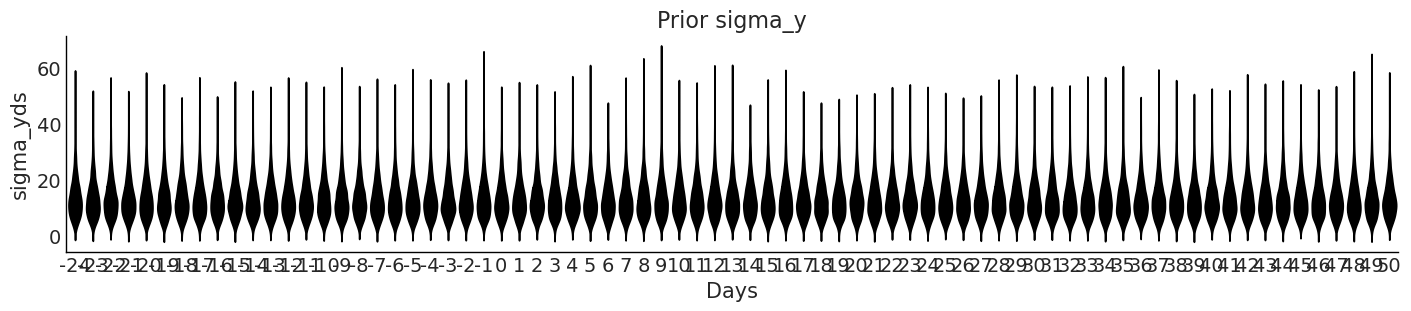

In [ ]:
plot_ds = xr.Dataset(data_vars={'day': day_range_, 'fish': cd.fish_, 'sigma_y': prior['σ']})

fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

plot_df = plot_ds.to_dataframe().reset_index()
plot_df['day'] = plot_df['day'].astype(int)
sns.violinplot(data=plot_df, x='day', y='sigma_y', ax=ax, inner='quartile')
ax.set_title(f'Prior sigma_y')
ax.set_xlabel('Days')
ax.set_ylabel('sigma_yds')

Text(0, 0.5, 'Yds')

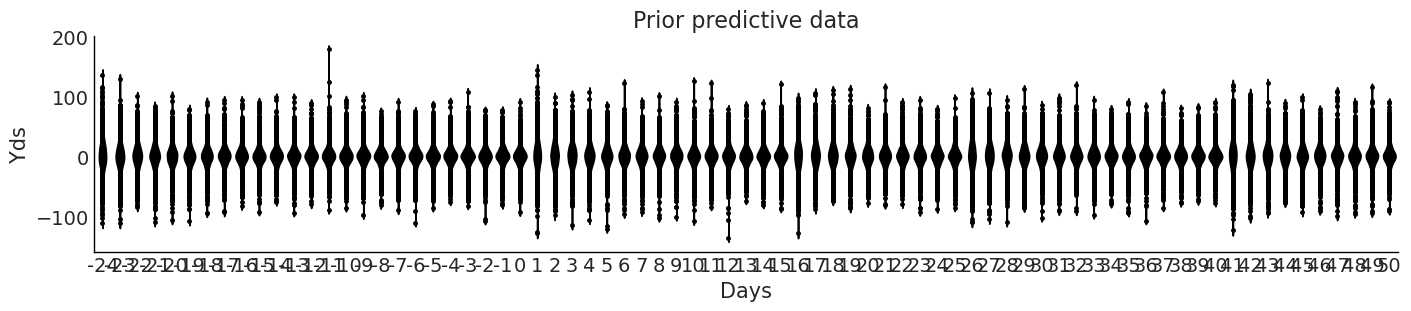

In [ ]:
plot_ds = xr.Dataset(data_vars={'day': day_range_, 'fish': cd.fish_, 'y_pp': pp['y']})

fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

plot_df = plot_ds.to_dataframe().reset_index()
plot_df['day'] = plot_df['day'].astype(int)
sns.violinplot(data=plot_df, x='day', y='y_pp', ax=ax, inner='point')
ax.set_title(f'Prior predictive data')
ax.set_xlabel('Days')
ax.set_ylabel('Yds')

Try sample

In [68]:
with m_yds:
    id_yds.extend(pm.sample(1000, tune=1000, target_accept=0.95, nuts={'max_treedepth':15}), join='right')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A_μμ, τ_μ, μ_μ_inf, A_σμ, σ_μ_inf, μ_std, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 458 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
id_yds

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [59]:
az.summary(id_yds, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], coords={'fish':3, 'stages': ['rotation','washout']})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A_μμ[rotation],-1.032,4.767,-9.553,8.312,0.111,0.079,1850.0,2394.0,1.0
A_μμ[washout],-0.875,5.461,-10.988,9.779,0.109,0.077,2514.0,2691.0,1.0
μ_μ_inf[rotation],-0.354,1.417,-2.982,2.216,0.031,0.026,2235.0,2061.0,1.0
μ_μ_inf[washout],-1.151,2.620,-5.861,3.895,0.046,0.037,3251.0,3071.0,1.0
A_σμ[rotation],6.934,4.340,0.743,14.963,0.116,0.082,1337.0,2331.0,1.0
A_σμ[washout],14.817,6.534,3.489,26.477,0.184,0.130,1199.0,1820.0,1.0
σ_μ_inf[rotation],0.877,0.715,0.000,2.187,0.012,0.008,3063.0,2198.0,1.0
σ_μ_inf[washout],3.158,2.186,0.007,7.014,0.042,0.030,2440.0,1915.0,1.0
τ_μ[rotation],4.220,3.422,0.201,10.230,0.074,0.052,1790.0,2342.0,1.0
τ_μ[washout],6.900,4.341,0.602,14.569,0.091,0.064,1779.0,1705.0,1.0


In [60]:
az.summary(id_yds, var_names=['A_μμ', 'A_σμ'], coords={'stages': ['rotation']})

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"A_μμ[3, rotation]",-1.032,4.767,-9.553,8.312,0.111,0.079,1850.0,2394.0,1.00
"A_μμ[7, rotation]",7.496,3.796,0.662,14.556,0.074,0.052,2625.0,2969.0,1.00
"A_μμ[9, rotation]",2.928,3.828,-4.081,10.232,0.079,0.056,2330.0,2691.0,1.00
"A_μμ[10, rotation]",-1.653,5.563,-11.710,8.837,0.117,0.083,2265.0,2914.0,1.00
"A_σμ[3, rotation]",6.934,4.340,0.743,14.963,0.116,0.082,1337.0,2331.0,1.00
"A_σμ[7, rotation]",4.689,2.763,0.438,9.730,0.057,0.041,2222.0,2353.0,1.00
"A_σμ[9, rotation]",4.397,2.704,0.336,9.200,0.051,0.036,2459.0,2539.0,1.00
"A_σμ[10, rotation]",22.422,5.982,11.760,34.063,0.164,0.116,1320.0,1882.0,1.01


<Axes: title={'center': 'tree_depth'}>

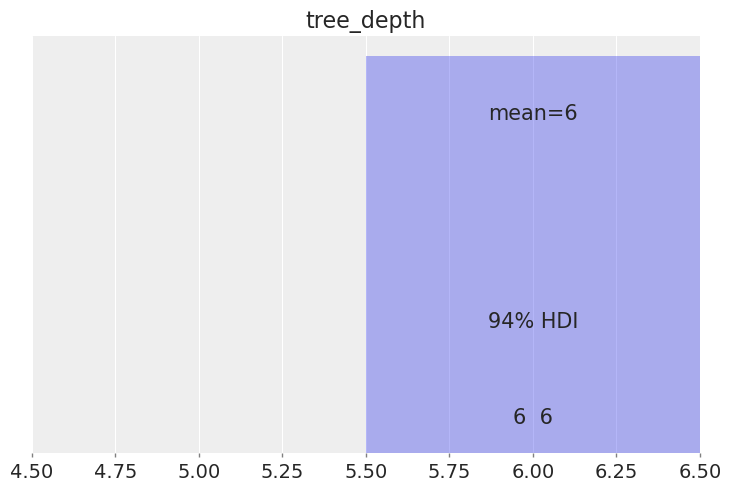

In [69]:
az.plot_posterior(id_yds, var_names="tree_depth", group="sample_stats")

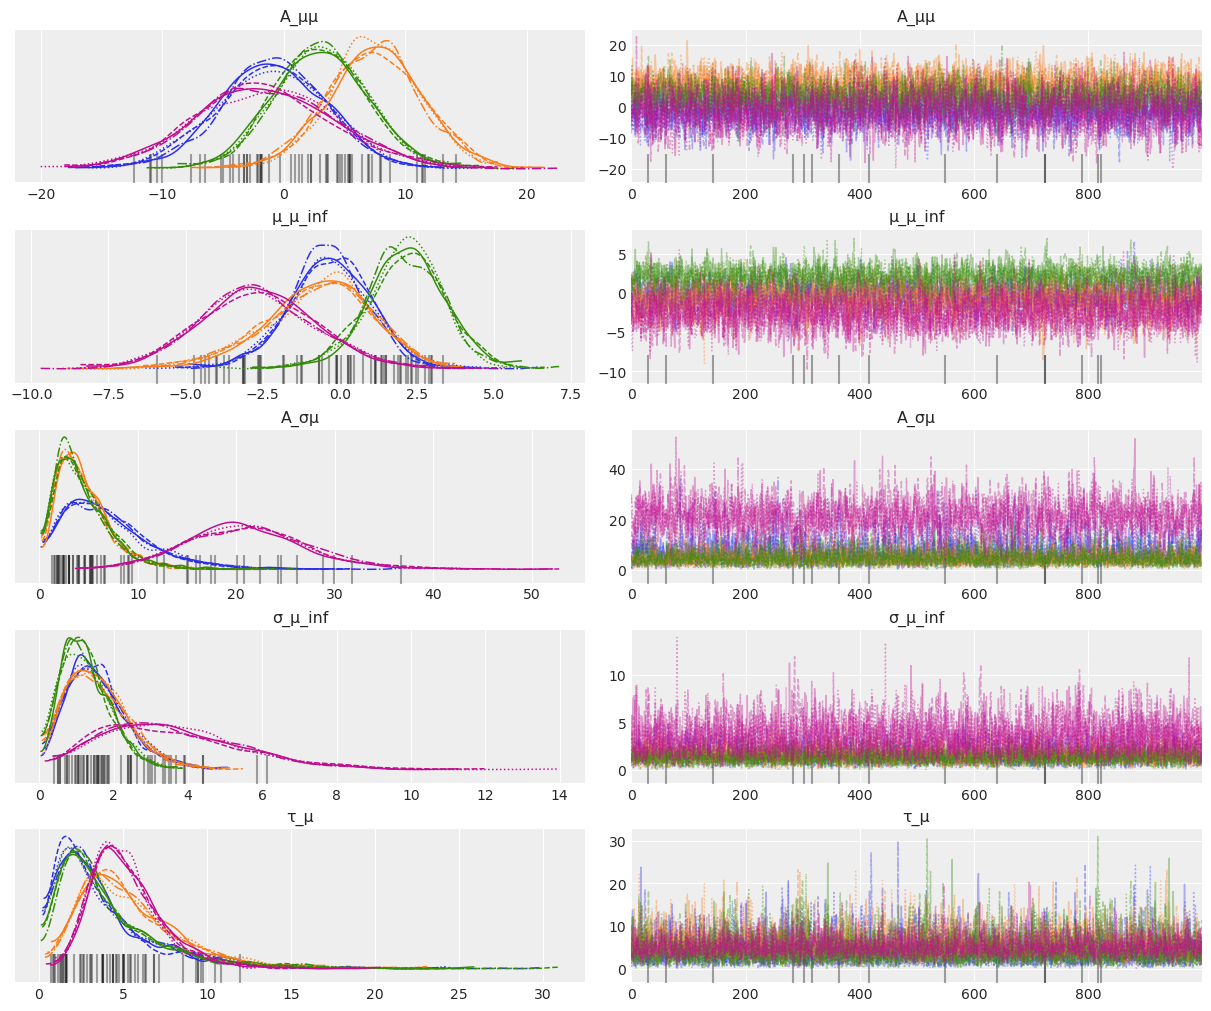

In [70]:
az.plot_trace(id_yds, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], coords={'stages': 'rotation'});

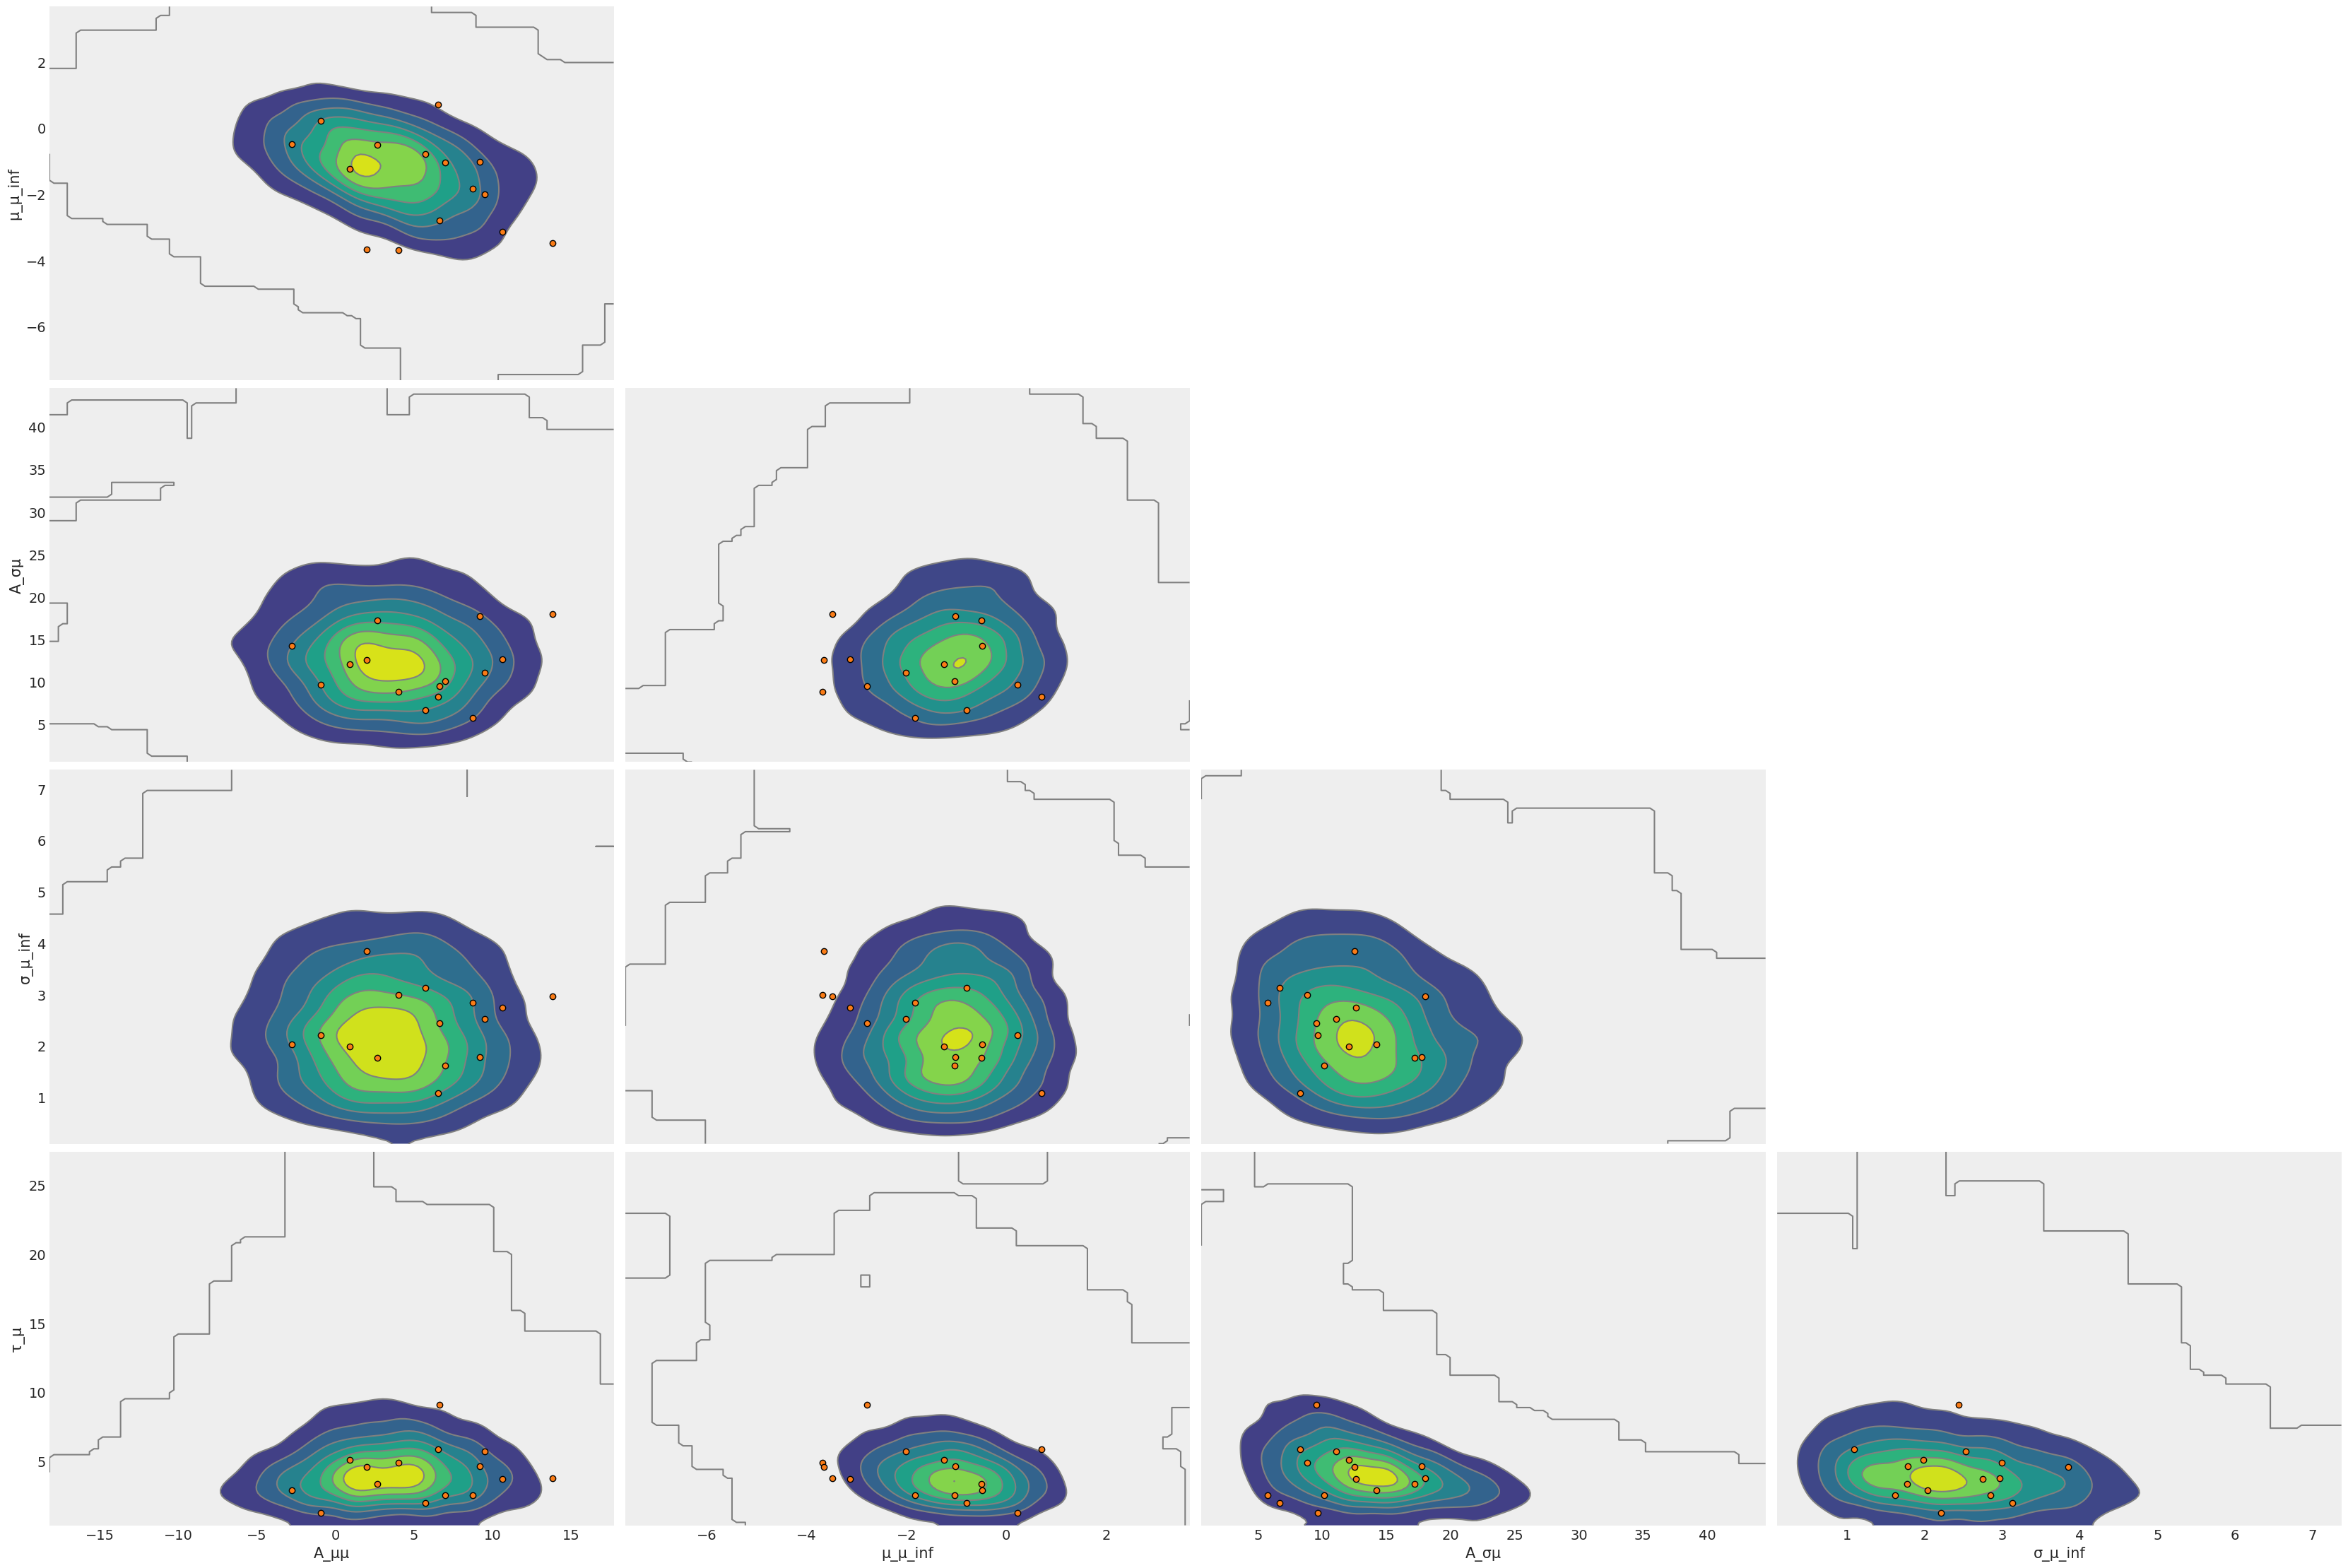

In [71]:
az.plot_pair(id_yds, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], 
             coords={'fish':10, 'stages': 'baseline'}, 
             divergences=True,
             kind='kde');

In [ ]:
%load_ext watermark
%watermark -v -iv -w

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.20.0

scipy     : 1.13.0
xarray    : 2024.3.0
pymc      : 5.12.0
seaborn   : 0.13.2
numpy     : 1.26.4
pandas    : 2.2.1
pytensor  : 2.19.0
arviz     : 0.18.0
matplotlib: 3.8.3

Watermark: 2.4.3

